# The *ecco_access* Python "package": accessing ECCO output on PO.DAAC

Andrew Delman, updated 2024-10-17

[Introduction](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_access_intro.html#Introduction)\
[Setting up *ecco_access*](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_access_intro.html#Setting-up-ecco_access)\
[Using the *ecco_podaac_to_xrdataset* function](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_access_intro.html#Using-the-ecco_podaac_to_xrdataset-function)\
[What if you don't know the ShortName already?](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_access_intro.html#What-if-you-dont-know-the-ShortName-already)\
[Using the *ecco_podaac_access* function](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_access_intro.html#Using-the-ecco_podaac_access-function)

## Introduction

In the past several years since ECCOv4 release 4 output was made available on the Physical Oceanography Distributed Active Archive Center or [PO.DAAC](https://podaac.jpl.nasa.gov), a number of Python scripts/functions have been written to facilitate requests of this output, authored by Jack McNelis, Ian Fenty, and Andrew Delman. To make access easier and standardize the format of these requests, the **ecco_access** library has been made available in the `ecco_access` folder of the [ECCO-v4-Python-Tutorial](https://github.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/tree/master/ecco_access) Github repository.

This tutorial will help you get set up with **ecco_access** so that you can use it from your tutorial directories on OSS or wherever else you need it. It also introduces the two top-level functions that you would likely use in **ecco_access**:

- `ecco_podaac_to_xrdataset`: takes as input a text query or ECCO dataset identifier, and returns an *xarray* Dataset

- `ecco_podaac_access`: takes the same input, but returns the URLs/paths or local files where the data is located


There are also a number of access modes for querying the datasets, downloading the datasets, or accessing through S3 cloud storage. For more examples of these modes, you can look at the [ECCO access modes](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_access_modes.html) tutorial.



## Setting up `ecco_access`

The *ecco_access* library I am calling a "package" in quotes because it currently has the core structure of any package you would install using `conda` or `pip`; there is an `__init__.py` file that allows you to access all of the library's modules and the functions within, using a single `import ecco_access` command. However, this "package" is not available through `conda` or `pip` yet.In the meantime, you can get `ecco_access` using one of the following methods:

- *git clone* the [ECCO-v4-Python-Tutorial](https://github.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/tree/master) repository, which contains *ecco_access* along with the symlinks (soft links) needed to run the tutorials in-place

- Download the *ecco_access* folder by clicking on [this link](https://download-directory.github.io/?url=https%3A%2F%2Fgithub.com%2FECCO-GROUP%2FECCO-v4-Python-Tutorial%2Ftree%2Fmaster%2Fecco_access).


If you downloaded the folder (second option), make sure the downloaded folder is unzipped/extracted and rename it to `ecco_access`. 

Then you need to make it accessible to your notebook, either by: 

### Adding the `ecco_access` parent directory to your Python path

The `ecco_access` parent directory is the directory containing `ecco_access`. Add it to your Python path with the following Python code in each notebook where `ecco_access` is used:

```
import sys
sys.path.append({parent_dir})
```

Or:

### Put in a symlink to the `ecco_access` location from your current notebook directory.

A symlink (or soft link) from the directory containing your notebooks will allow you to use the `ecco_access` libraries from any notebook in that directory. Put in the link with the following code in your terminal window:

```
ln -s {parent_dir}/ecco_access {current_notebook_dir}/ecco_access
```

or by running the following Python code once:

```
import os
os.symlink('{location_of_ecco_access}/ecco_access','{current_notebook_dir}/ecco_access',target_is_directory=True)
```

After you have done this you should be able to import *ecco_access* just like any other Python package.


## Using the `ecco_podaac_to_xrdataset` function

Perhaps the most convenient way to use *ecco_access* is the `ecco_podaac_to_xrdataset`; it takes as input a *query* consisting of NASA Earthdata dataset ShortName(s), ECCO variables, or text strings in the variable descriptions, and outputs an *xarray* Dataset. Let's look at the syntax:

In [1]:
import numpy as np
import xarray as xr
from os.path import join,expanduser
import matplotlib.pyplot as plt

import ecco_access as ea

# identify user's home directory
user_home_dir = expanduser('~')

In [2]:
help(ea.ecco_podaac_to_xrdataset)

Help on function ecco_podaac_to_xrdataset in module ecco_access.ecco_access:

ecco_podaac_to_xrdataset(query, version='v4r4', grid=None, time_res='all', StartDate=None, EndDate=None, snapshot_interval=None, mode='download_ifspace', download_root_dir=None, **kwargs)
    This function queries and accesses ECCO datasets from PO.DAAC. The core query and download functions are adapted from Jupyter notebooks
    created by Jack McNelis and Ian Fenty
    (https://github.com/ECCO-GROUP/ECCO-ACCESS/blob/master/PODAAC/Downloading_ECCO_datasets_from_PODAAC/README.md)
    and modified by Andrew Delman (https://ecco-v4-python-tutorial.readthedocs.io).
    It is similar to ecco_podaac_access, except instead of a list of URLs or files,
    an xarray Dataset with all of the queried ECCO datasets is returned.

    Parameters
    ----------
    query: str, list, or dict, defines datasets or variables to access.
           If query is str, it specifies either a dataset ShortName (if query
           matc

There are a lot of options that you *can* use to "submit" a query with this function. Let's consider a simple case, where we already have the ShortName for the [monthly native grid SSH](https://raw.githubusercontent.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/master/varlist/v4r4_nctiles_monthly_varlist.txt) from ECCOv4r4 (**ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4**), and we want to access output from the year 2017. The ShortName goes in the query field, and we can specify start and end dates (in *YYYY-MM* or *YYYY-MM-DD* format). The other options that matter most for this request are the *mode*, and depending on the mode, the *download_root_dir* or the *jsons_root_dir*.

### Direct download over the internet (mode = 'download')

Let's try the **download** mode, which retrieves the data over the Internet using NASA Earthdata URLs (this should work on any machine with Internet access, including cloud environments):

In [3]:
# download data and open xarray dataset
curr_shortname = 'ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4'
ds_SSH = ea.ecco_podaac_to_xrdataset(curr_shortname,\
                                        StartDate='2017-01',EndDate='2017-12',\
                                        mode='download',\
                                        download_root_dir=join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC'))

created download directory /home/jovyan/Downloads/ECCO_V4r4_PODAAC/ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4
DL Progress: 100%|#########################| 12/12 [00:05<00:00,  2.16it/s]

total downloaded: 71.02 Mb
avg download speed: 12.76 Mb/s
Time spent = 5.56673002243042 seconds




We specified a *root* directory for the download (which also happens to be the default setting), and the data files are then placed under *download_root_dir* / ShortName. We can verify that the contents of the file are what we queried:

In [4]:
ds_SSH

<xarray.Dataset> Size: 24MB
Dimensions:    (time: 11, tile: 13, j: 90, i: 90, i_g: 90, j_g: 90, nv: 2, nb: 4)
Coordinates: (12/13)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 88B 2017-01-16T12:00:00 ... 2017-11-16
    ...         ...
    YC         (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XG         (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YG         (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] 176B dask.array<chunksize=(1, 2), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
Dimensions without coordinates: nv, nb
Data variables:
    SSH        (time, tile, j, i) float32 5MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    SSHIBC     (time, tile, j, i) float32 5MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    SSHNOIBC   (time, tile, j, i) float32 5MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    ETAN       (time, tile, j, i) float32 5MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            2017-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          2017-01-01T00:00:00
    title:                        ECCO Sea Surface Height - Monthly Mean llc9...
    uuid:                         a21a5c30-400c-11eb-a9e0-0cc47a3f49c3

### In-cloud direct access (mode = 's3_open')

If you are working in the AWS Cloud, you do not have to download the ECCO output files to carry out computations with the data. Let's try **s3_open**, which opens the files from S3 (no download necessary).

In [5]:
curr_shortname = 'ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4'
ds_SSH_s3 = ea.ecco_podaac_to_xrdataset(curr_shortname,\
                                        StartDate='2017-01',EndDate='2017-12',\
                                        mode='s3_open')

{'ShortName': 'ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4', 'temporal': '2017-01-02,2017-12-31'}

Total number of matching granules: 12


In [6]:
ds_SSH_s3

<xarray.Dataset> Size: 25MB
Dimensions:    (time: 12, tile: 13, j: 90, i: 90, i_g: 90, j_g: 90, nv: 2, nb: 4)
Coordinates: (12/13)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 96B 2017-01-16T12:00:00 ... 2017-12-16T0...
    ...         ...
    YC         (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XG         (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YG         (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
Dimensions without coordinates: nv, nb
Data variables:
    SSH        (time, tile, j, i) float32 5MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    SSHIBC     (time, tile, j, i) float32 5MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    SSHNOIBC   (time, tile, j, i) float32 5MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    ETAN       (time, tile, j, i) float32 5MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            2017-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          2017-01-01T00:00:00
    title:                        ECCO Sea Surface Height - Monthly Mean llc9...
    uuid:                         a21a5c30-400c-11eb-a9e0-0cc47a3f49c3

Now plot the SSH for Jan 2017 in tile 10 (Python numbering convention; 11 in Fortran/MATLAB numbering convention). Here we use the "RdYlBu" colormap, one of [many built-in colormaps](https://matplotlib.org/stable/gallery/color/colormap_reference.html) that the `matplotlib` package provides, or you can [create your own](https://matplotlib.org/stable/users/explain/colors/colormap-manipulation.html#colormap-manipulation). The "_r" at the end reverses the direction of the colormap, so red corresponds to the maximum values.

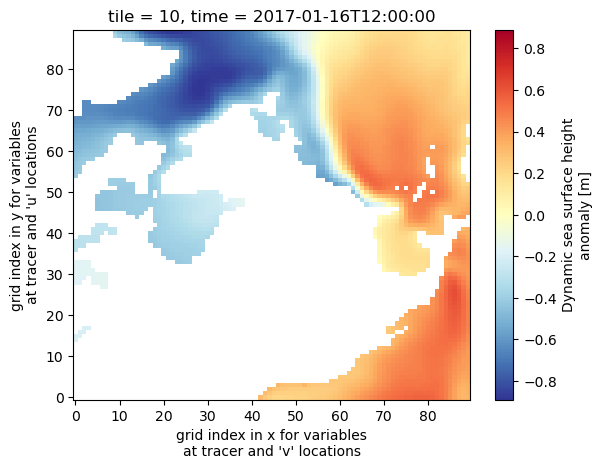

In [7]:
ds_SSH_s3.SSH.isel(time=0,tile=10).plot(cmap='RdYlBu_r')

We can also use the `ecco_v4_py` package to plot a global map of Jan 2017 SSH, using the `plot_proj_to_latlon_grid` function which regrids from the native LLC grid to a lat/lon grid.

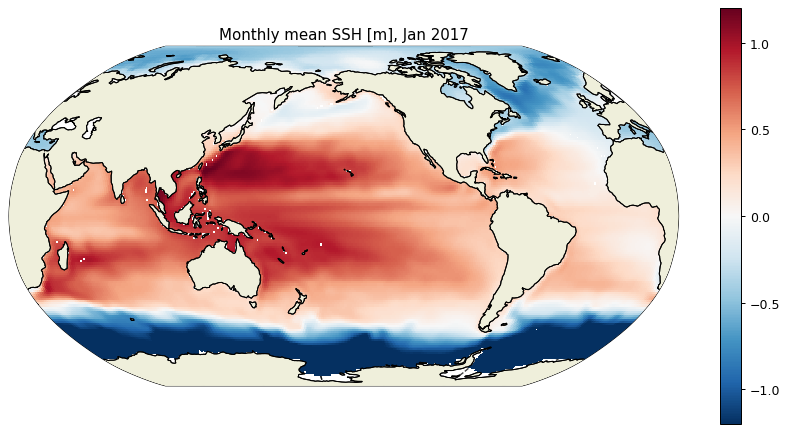

In [8]:
import ecco_v4_py as ecco

plt.figure(figsize=(12,6), dpi= 90)
ecco.plot_proj_to_latlon_grid(ds_SSH_s3.XC, ds_SSH_s3.YC, \
                              ds_SSH_s3.SSH.isel(time=0), \
                              user_lon_0=-160,\
                              projection_type='robin',\
                              plot_type='pcolormesh', \
                              cmap='RdBu_r',\
                              dx=1,dy=1,cmin=-1.2, cmax=1.2,show_colorbar=True)
plt.title('Monthly mean SSH [m], Jan 2017')
plt.show()

## What if you don't know the ShortName already?

[NASA Earthdata](https://search.earthdata.nasa.gov/search) datasets are identified by ShortNames, but you might not know the ShortName of the variable or category of variables that you are seeking. One way to find the ShortName is to consult the ECCOv4r4 variable lists:

[ECCO v4r4 llc90 Grid Dataset Variables - Monthly Means](https://raw.githubusercontent.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/master/varlist/v4r4_nctiles_monthly_varlist.txt)

[ECCO v4r4 llc90 Grid Dataset Variables - Daily Means](https://raw.githubusercontent.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/master/varlist/v4r4_nctiles_daily_varlist.txt)

[ECCO v4r4 llc90 Grid Dataset Variables - Daily Snapshots](https://raw.githubusercontent.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/master/varlist/v4r4_nctiles_snapshots_varlist.txt)

[ECCO v4r4 0.5-Deg Interp Grid Dataset Variables - Monthly Means](https://raw.githubusercontent.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/master/varlist/v4r4_latlon_monthly_varlist.txt)

[ECCO v4r4 0.5-Deg Interp Grid Dataset Variables - Daily Means](https://raw.githubusercontent.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/master/varlist/v4r4_latlon_daily_varlist.txt)

[ECCO v4r4 Time Series and Grid Parameters](https://raw.githubusercontent.com/ECCO-GROUP/ECCO-v4-Python-Tutorial/master/varlist/v4r4_tseries_grid_varlist.txt)

Another option is that you can specify a text string "query" in `ecco_access` functions. If "query" does not match an existing NASA Earthdata ShortName, it will conduct a case-insensitive search for exact matches of that text string among the variable names and descriptions in the variable lists.

> Note: if using a "query" to search the variable lists, it is recommended to use a single word (or even part of a word) when possible. Since only exact text matches are identified, you are more likely to get results with a shorter query.

For example, perhaps you are looking to open the dataset that has native grid monthly sea ice concentration in 2007. If the query is not identified as a ShortName, then a text search of the [variable lists](https://ecco-hackweek.github.io/ecco-2024/tutorials/ECCO_data_access/ECCO_data_structure.html#dataset-shortnames-and-variables-associated-with-them) is conducted using *query*, *grid*, and *time_res*. Then of the identified matches, the user is asked to select one.

In [9]:
ds_seaice_conc = ea.ecco_podaac_to_xrdataset('ice',grid='native',time_res='monthly',\
                                               StartDate='2007-01',EndDate='2007-12',\
                                               mode='s3_open')

ShortName Options for query "ice":
                  Variable Name     Description (units)

Option 1: ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4    *native grid,monthly means*
                  SSH               Dynamic sea surface height anomaly. Suitable for
                                    comparisons with altimetry sea surface height data
                                    products that apply the inverse barometer
                                    correction. (m)
                  SSHIBC            The inverted barometer correction to sea surface
                                    height due to atmospheric pressure loading. (m)
                  SSHNOIBC          Sea surface height anomaly without the inverted
                                    barometer correction. Suitable for comparisons
                                    with altimetry sea surface height data products
                                    that do NOT apply the inverse barometer
                                

Please select option [1-8]:  5


Using dataset with ShortName: ECCO_L4_SEA_ICE_CONC_THICKNESS_LLC0090GRID_MONTHLY_V4R4
{'ShortName': 'ECCO_L4_SEA_ICE_CONC_THICKNESS_LLC0090GRID_MONTHLY_V4R4', 'temporal': '2007-01-02,2007-12-31'}

Total number of matching granules: 12


We selected option 5, corresponding to ShortName ECCO_L4_SEA_ICE_CONC_THICKNESS_LLC0090GRID_MONTHLY_V4R4. Let's look at the dataset contents.

In [10]:
ds_seaice_conc

<xarray.Dataset> Size: 25MB
Dimensions:    (time: 12, tile: 13, j: 90, i: 90, i_g: 90, j_g: 90, nv: 2, nb: 4)
Coordinates: (12/13)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 96B 2007-01-16T12:00:00 ... 2007-12-16T1...
    ...         ...
    YC         (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XG         (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YG         (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
Dimensions without coordinates: nv, nb
Data variables:
    SIarea     (time, tile, j, i) float32 5MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    SIheff     (time, tile, j, i) float32 5MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    SIhsnow    (time, tile, j, i) float32 5MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    sIceLoad   (time, tile, j, i) float32 5MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            2007-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          2007-01-01T00:00:00
    title:                        ECCO Sea-Ice and Snow Concentration and Thi...
    uuid:                         e6cdf192-400d-11eb-93b5-0cc47a3f49c3

Now plot the sea ice concentration/fraction in tile 6 (which approximately covers the Arctic Ocean), during Sep 2007 which at the time was a record minimum for Arctic sea ice.

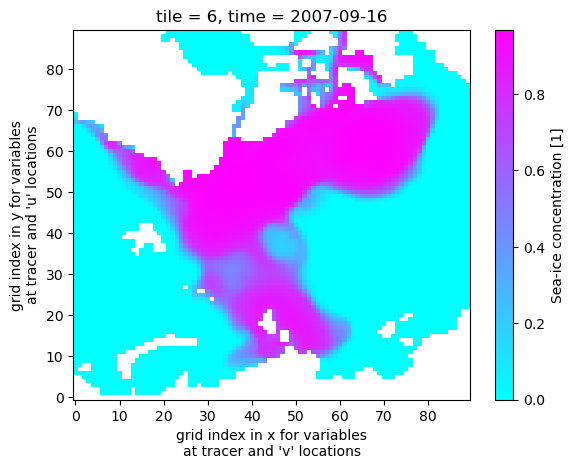

In [11]:
ds_seaice_conc.SIarea.isel(time=8,tile=6).plot(cmap='cool')

## Using the `ecco_podaac_access` function

### In-cloud direct access (mode = 's3_open')

The `ecco_podaac_to_xrdataset` function that was previously used invokes `ecco_podaac_access` under the hood, and `ecco_podaac_access` can also be called directly. This can be useful if you want to obtain a list of file objects/paths or URLs that you can then process with your own code. Let's use this function with mode = `s3_open` (all `s3` modes only work from an AWS cloud environment in region `us-west-2`).

In [12]:
files_dict = ea.ecco_podaac_access(curr_shortname,\
                                    StartDate='2015-01',EndDate='2015-12',\
                                    mode='s3_open')

{'ShortName': 'ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4', 'temporal': '2015-01-02,2015-12-31'}

Total number of matching granules: 12


In [13]:
files_dict[curr_shortname]

[<File-like object S3FileSystem, podaac-ops-cumulus-protected/ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4/SEA_SURFACE_HEIGHT_mon_mean_2015-01_ECCO_V4r4_native_llc0090.nc>,
 <File-like object S3FileSystem, podaac-ops-cumulus-protected/ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4/SEA_SURFACE_HEIGHT_mon_mean_2015-02_ECCO_V4r4_native_llc0090.nc>,
 <File-like object S3FileSystem, podaac-ops-cumulus-protected/ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4/SEA_SURFACE_HEIGHT_mon_mean_2015-03_ECCO_V4r4_native_llc0090.nc>,
 <File-like object S3FileSystem, podaac-ops-cumulus-protected/ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4/SEA_SURFACE_HEIGHT_mon_mean_2015-04_ECCO_V4r4_native_llc0090.nc>,
 <File-like object S3FileSystem, podaac-ops-cumulus-protected/ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4/SEA_SURFACE_HEIGHT_mon_mean_2015-05_ECCO_V4r4_native_llc0090.nc>,
 <File-like object S3FileSystem, podaac-ops-cumulus-protected/ECCO_L4_SSH_LLC0090GRID_MONTHLY_V4R4/SEA_SURFACE_HEIGHT_mon_mean_2015-06_ECCO_V4r4_native_llc0090.nc>,
 <File-lik

The output of `ecco_podaac_access` is in the form of a dictionary with ShortNames as keys. In this case, the value associated with this ShortName is a list of 12 file objects. These are files on `S3` (AWS's cloud storage system) that have been opened, which is a necessary step for the files' data to be accessed. The list of open files can be passed directly to `xarray.open_mfdataset`.

In [14]:
ds_SSH_fromlist = xr.open_mfdataset(files_dict[curr_shortname],\
                                    compat='override',data_vars='minimal',coords='minimal',\
                                    parallel=True)

In [15]:
ds_SSH_fromlist

<xarray.Dataset> Size: 25MB
Dimensions:    (time: 12, tile: 13, j: 90, i: 90, i_g: 90, j_g: 90, nv: 2, nb: 4)
Coordinates: (12/13)
  * i          (i) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * i_g        (i_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * j          (j) int32 360B 0 1 2 3 4 5 6 7 8 9 ... 81 82 83 84 85 86 87 88 89
  * j_g        (j_g) int32 360B 0 1 2 3 4 5 6 7 8 ... 81 82 83 84 85 86 87 88 89
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 96B 2015-01-16T12:00:00 ... 2015-12-16T1...
    ...         ...
    YC         (tile, j, i) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    XG         (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    YG         (tile, j_g, i_g) float32 421kB dask.array<chunksize=(13, 90, 90), meta=np.ndarray>
    time_bnds  (time, nv) datetime64[ns] 192B dask.array<chunksize=(1, 2), meta=np.ndarray>
    XC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
    YC_bnds    (tile, j, i, nb) float32 2MB dask.array<chunksize=(13, 90, 90, 4), meta=np.ndarray>
Dimensions without coordinates: nv, nb
Data variables:
    SSH        (time, tile, j, i) float32 5MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    SSHIBC     (time, tile, j, i) float32 5MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    SSHNOIBC   (time, tile, j, i) float32 5MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
    ETAN       (time, tile, j, i) float32 5MB dask.array<chunksize=(1, 13, 90, 90), meta=np.ndarray>
Attributes: (12/57)
    acknowledgement:              This research was carried out by the Jet Pr...
    author:                       Ian Fenty and Ou Wang
    cdm_data_type:                Grid
    comment:                      Fields provided on the curvilinear lat-lon-...
    Conventions:                  CF-1.8, ACDD-1.3
    coordinates_comment:          Note: the global 'coordinates' attribute de...
    ...                           ...
    time_coverage_duration:       P1M
    time_coverage_end:            2015-02-01T00:00:00
    time_coverage_resolution:     P1M
    time_coverage_start:          2015-01-01T00:00:00
    title:                        ECCO Sea Surface Height - Monthly Mean llc9...
    uuid:                         a4955186-400c-11eb-8c14-0cc47a3f49c3